## High Speed Video File Inspection and Conversion
This script is intended to inspect and convert .cine files\
from Phantom high speed video cameras.

In [1]:
# author: Wandeclayt M.
# version: 0.1.9
# license: CC-BY-NC 4.0
# www.github.com/masterhit/

In [2]:
import os
import rawpy
import imageio
import cv2
import ctypes as ct
import struct
import numpy as np
from pycine import cine
from matplotlib import pyplot as plt
from tqdm import tqdm
import subprocess

### First Frame Inspection

this function inspects a .cine file, displays its first frame\
and computes the total number of frames.

In [3]:
# BASIC INFO - DISPLAYS FIRST FRAME

def inspect_cine_video(file_path):
    try:
        # Open the video file using imageio
        video = imageio.get_reader(file_path, 'ffmpeg')
        
        # Get video properties
        meta_data = video.get_meta_data()
        
        # Extract resolution
        frame_width, frame_height = meta_data.get('size', (None, None))
        frame_count = meta_data.get('nframes', None)
        
        # Sometimes frame count may be unknown, handle this case
        if frame_count is None or frame_count == float('inf'):
            print("Frame count is unknown or infinite, attempting to calculate based on frame reads.")
            # Read frames to count manually (stops at first broken frame)
            frame_count = 0
            try:
                while True:
                    video.get_data(frame_count)
                    frame_count += 1
            except IndexError:
                print(f"Total frame count calculated: {frame_count}")

        print(f"Video Resolution: {frame_width}x{frame_height}")
        print(f"Total Number of Frames: {frame_count}")

        # Read the first frame
        frame = video.get_data(0)
        
        # Convert the frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the first frame
        plt.imshow(frame_rgb)
        plt.title('Frame 0')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

### Full Header Inspection

In [4]:
# Function to read the .cine header
def read_cine_header(file_path):
    """
    This function reads the header of a .cine file, including the cinefileheader, bitmapinfoheader, and setup structure.
    It also retrieves additional metadata like image offsets, timestamps, and exposure times.
    """
    try:
        # Initialize the header dictionary with different header components.
        header = {
            "cinefileheader": cine.CINEFILEHEADER(),  # CINEFILEHEADER structure
            "bitmapinfoheader": cine.BITMAPINFOHEADER(),  # BITMAPINFOHEADER structure
            "setup": cine.SETUP(),  # SETUP structure
            "pImage": [],  # Placeholder for image offsets
            "timestamp": np.empty(0),  # Placeholder for timestamps (will store timestamps for frames)
            "exposuretime": np.empty(0),  # Placeholder for exposure times (stores exposure data per frame)
        }

        # Open the .cine file in binary read mode
        with open(file_path, "rb") as f:
            # Read the cinefileheader and bitmapinfoheader into their respective structures
            f.readinto(header["cinefileheader"])
            f.readinto(header["bitmapinfoheader"])

            # Move the file pointer to the offset where the setup structure is stored
            f.seek(header["cinefileheader"].OffSetup)
            f.readinto(header["setup"])  # Read the setup structure

            # Seek to the position where the image offsets start
            f.seek(header["cinefileheader"].OffImageOffsets)
            
            # Read the image offsets into pImage list
            # ImageCount tells us how many images (frames) are there
            header["pImage"] = struct.unpack(
                f"{header['cinefileheader'].ImageCount}q", 
                f.read(header["cinefileheader"].ImageCount * 8)  # Reading 8 bytes per image offset
            )

            # Retrieve additional tagged block information like timestamps and exposure times
            header = read_tagged_block(f, header)

        return header  # Return the populated header dictionary

    except Exception as e:
        print(f"Error reading cine file: {e}")  # Handle any exceptions and print the error message

# Helper function to read tagged blocks from the .cine file
def read_tagged_block(f, header):
    """
    Reads tagged blocks from the .cine file to extract additional metadata like timestamps and exposure times.
    """
    # Calculate the position in the file where the tagged blocks start
    position = ct.sizeof(header["cinefileheader"]) + ct.sizeof(header["bitmapinfoheader"]) + header["setup"].Length
    f.seek(position)  # Move file pointer to that position
    
    while position < header["cinefileheader"].OffImageOffsets:
        # Read the size of the next block
        blocksize = np.frombuffer(f.read(4), dtype="uint32")[0]
        
        # Read the tag type (determines the type of data in the block)
        tagtype = np.frombuffer(f.read(2), dtype="uint16")[0]
        
        f.seek(2, 1)  # Skip 2 reserved bytes

        # Check if the block is a time-only block
        if tagtype == 1002:  # Time-only block tag
            temp = np.frombuffer(f.read(blocksize - 8), dtype="uint32").reshape(header["cinefileheader"].ImageCount, -1)
            header["timestamp"] = temp[:, 1] + (((2 ** 32 - 1) & temp[:, 0]) / (2 ** 32))

        # Check if the block is an exposure-only block
        elif tagtype == 1003:  # Exposure-only block tag
            header["exposuretime"] = np.frombuffer(f.read(blocksize - 8), dtype="uint32") * 2 ** -32

        # If the block is of a different type, just skip over it
        else:
            f.seek(blocksize - 8, 1)

        # Move the position pointer to the next block
        position += blocksize

    return header  # Return the updated header with tagged block information

# Function to nicely format and print the header fields
def display_cine_header(header):
    """
    Displays the .cine file header information in a readable format.
    """
    print("===== Cine File Header Information =====")
    print(file_path)
    # Extract the different parts of the header
    cinefileheader = header["cinefileheader"]
    bitmapinfoheader = header["bitmapinfoheader"]
    setup = header["setup"]
    
    # Display the key fields of interest from the headers
    print(f"Width: {bitmapinfoheader.biWidth}")  # Image width
    print(f"Height: {bitmapinfoheader.biHeight}")  # Image height
    print(f"bitCount: {bitmapinfoheader.biBitCount}")  # Bit depth of the image
    print(f"Image Count: {cinefileheader.ImageCount}")  # Total number of images (frames)
    print(f"Frame Rate: {setup.FrameRate}")  # Frame rate (in frames per second)
    print(f"Size Image: {bitmapinfoheader.biSizeImage}")  #
    print(f"Serial Number: {setup.Serial}")  # Serial number of the camera
    print(f"Camera Version: {setup.CameraVersion}")  # Camera version used
    print(f"First Image Offset: {cinefileheader.OffImageOffsets}")  # Offset where the first image starts

    # Commented out fields for timestamps and exposure times (can be included if needed)
    print(f"Timestamp Data: {header['timestamp'][0]}")
    # print(f"Exposure Time Data: {header['exposuretime']}")




### File Conversion

In [15]:
#import os
#import rawpy
#import imageio
#import cv2
#from matplotlib import pyplot as plt

def convert_cine_video(file_path):
    try:
        # Open the video file
        video = imageio.get_reader(file_path, 'ffmpeg')

        # Read the first frame
        frame = video.get_data(0)
        
        # Convert the frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the first frame
        plt.imshow(frame_rgb)
        plt.title('First Frame')
        plt.axis('off')
        plt.show()

        # Ask user for video format conversion
        convert_format = input("Do you want to convert this video to MP4 (m) or MOV (v)? Enter 'm' or 'v': ")
        
        test_number = input("Enter test number: ")

        if convert_format.lower() == 'm':
            output_file = os.path.splitext(file_path)[0] + '_python' + test_number + '.mp4'
        elif convert_format.lower() == 'v':
            output_file = os.path.splitext(file_path)[0] + '_python' + test_number + '.mov'
        else:
            print("Invalid choice. Video not converted.")
            return
        
        # Use ffmpeg to convert the video
        #cmd = f"ffmpeg -i {file_path} -c:v libx264 -preset slow -crf 10 -c:a aac -b:a 128k {output_file}"
        #os.system(cmd)
        #print(f"Video converted successfully to {output_file}")
        
        # Use ffmpeg to convert the video
        cmd = f"ffmpeg -r 24 -i {file_path} -c:v libx264 -preset slow -crf 0 -an {output_file}"
        os.system(cmd)
        print(f"Video converted successfully to {output_file}")

    except Exception as e:
        print(f"Error: {e}")

===== Cine File Header Information =====
01_Raw/2023_12_12_Ensaio61/c_26505_567.cine
Width: 640
Height: 576
bitCount: 16
Image Count: 1677
Frame Rate: 10000
Size Image: 460800
Serial Number: 26505
Camera Version: 7011
First Image Offset: 29568
Timestamp Data: 1702384637.74354


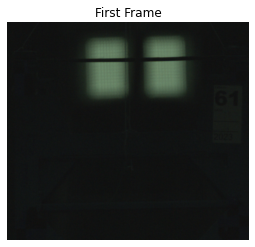

Do you want to convert this video to MP4 (m) or MOV (v)? Enter 'm' or 'v':  v
Enter test number:  61


Video converted successfully to 01_Raw/2023_12_12_Ensaio61/c_26505_567_python61.mov


In [19]:
# Provide the path to the .cine file
file_path = "01_Raw/2023_12_12_Ensaio61/c_26505_567.cine"

# Read and display the header information
header = read_cine_header(file_path)
display_cine_header(header)
#inspect_cine_video(file_path)
convert_cine_video(file_path)

### Cine File Header Attributes

```
Available attributes in the 'setup' object:
AnaBoard
AnaChannels
AnaGain
AnaName
AnaOption
AnaUnit
AspectRatio
AutoExpLevel
AutoExpRect
AutoExpSpeed
AutoExposure
BinChannels
BinName
BlackCalSVer
BlackLevel
Bright
CFA
CICalib
CalibEDR
CalibExp
CalibHeight
CalibRate
CalibTemp
CalibWidth
CalibrationInfo
CameraVersion
ChOption
CineName
Contrast
Conv8Max
Conv8Min
CreatedBy
CropRect
Decimation
Description
DescriptionOld
EDRShutter
EDRShutter16
EDRShutterNs
EnableCrop
EnableMatrices
EnableResample
FRPExp
FRPImgNr
FRPRate
FRPShape
FRPSteps
FilterCode
FilterParam
FilterTime
FirmwareVersion
FrameDelay
FrameDelay16
FrameDelayNs
FrameRate
FrameRate16
Gamma
GpsInfo
GrayCalSVer
Grid
HeadSerial
Hue
ImHeight
ImHeightAcq
ImPosXAcq
ImPosYAcq
ImWidth
ImWidthAcq
Length
LensAperture
LensDescription
LensFocalLength
LensFocusDistance
LogMode
LongReady
LowestFormatBPP
LowestFormatQ
MCCnt
MCPercent
Mark
MasterSerial
OpticalFilter
PostTrigger
PostTrigger16
RangeCode
RangeSize
RealBPP
RecBPP
RecordingTimeZone
Res1
Res10
Res11
Res12
Res13
Res14
Res15
Res16
Res17
Res18
Res19
Res2
Res20
Res21
Res3
Res4
Res5
Res6
Res7
Res8
Res9
ResampleHeight
ResampleWidth
RisingEdge
Rotate
SamplesPerImage
Saturation
Sensor
Serial
Shutter
Shutter16
ShutterNs
ShutterOff
SigOption
SoftwareVersion
SoundDest
ToneLabel
TonePoints
TrigFrame
TrigTC
UF
UserMatrixLabel
Uuid
WBGain
WBView
WhiteCalSVer
WhiteLevel
__class__
__ctypes_from_outparam__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_b_base_
_b_needsfree_
_fields_
_objects
_pack_
bEnableColor
bFlipH
bFlipV
bMetaWB
bStampTime
cmCalib
cmUser
dwImageCount
fChroma
fFlare
fGain
fGain16_8
fGainB
fGainG
fGainR
fGamma
fGammaB
fGammaR
fHue
fOffset
fPbRate
fPedestalB
fPedestalG
fPedestalR
fSaturation
fTcRate
fToe
fTone
fWBCc
fWBTemp
lFirstImage
nQFactor
szCinePath
wCineFileType

Available attributes in the 'cinefileheader' object:
Compression
FirstImageNo
FirstMovieImage
Headersize
ImageCount
OffImageHeader
OffImageOffsets
OffSetup
TotalImageCount
TriggerTime
Type
Version
__class__
__ctypes_from_outparam__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_b_base_
_b_needsfree_
_fields_
_objects

Available attributes in the 'bitmapinfoheader' object:
__class__
__ctypes_from_outparam__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_b_base_
_b_needsfree_
_fields_
_objects
biBitCount
biClrImportant
biClrUsed
biCompression
biHeight
biPlanes
biSize
biSizeImage
biWidth
biXPelsPerMeter
biYPelsPerMeter
```